## Import necessary modules

In [2]:
import timm
import torch
from PIL import Image
import requests
from timm.data import resolve_data_config, create_transform
from model import lsnet
from model.lsnet import LKP
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
import types
import copy

## Define functions

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def load_model(name: str):
    model = timm.create_model(f'hf_hub:jameslahm/{name}', pretrained=True)
    model.to(device)
    return model

def load_image(url: str):
    headers = {'User-Agent': 'Mozilla/5.0'}
    return Image.open(requests.get(url, headers=headers, stream=True).raw).convert('RGB')

def get_feature_maps(original_model, layer: str, image: Image.Image, off_LKP=False, high_res=False):
    model = copy.deepcopy(original_model)
    model.to(device)
    model.eval()
    feature_maps = []

    if off_LKP:
        count = 0
        for module in model.modules():
            if isinstance(module, LKP):
                module.cv2 = torch.nn.Identity()
                count += 1

        print(f"Removed {count} large kernel depth-wise convolution in LKP")
    
    def get_features():
        def hook(model, input, output):
            feature_maps.append(output.detach())
        return hook
    
    handle = eval(f"model.{layer}").register_forward_hook(get_features())

    config = resolve_data_config({}, model=model)
    transform = create_transform(**config)

    mean = config['mean']
    std = config['std']

    if high_res:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    input_tensor = transform(image).unsqueeze(0).to(device)

    try:
        with torch.no_grad():
            _ = model(input_tensor)
    except Exception as e:
        print(e)
        pass

    fmap = feature_maps[0]
    print(f"Feature map with shape: {fmap.shape}")

    handle.remove()

    return fmap

def plot_feature_maps(feature_maps, title: str, size=None, cmap='viridis'):
    fmap = feature_maps.squeeze(0)
    if fmap.ndim > 3:
        fmap = fmap.flatten(0, fmap.ndim - 3)
    print(fmap.shape)
    abs_fmap = torch.abs(fmap)
    heatmap = torch.mean(abs_fmap, dim=0) # [H, W]

    # Chuẩn hóa về 0-1
    heatmap_np = heatmap.cpu().numpy()
    heatmap_np = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)

    heatmap_smooth = heatmap_np
    # Resize về kích thước ảnh gốc (Làm mịn giống Code 2)
    if size:
        heatmap_smooth = cv2.resize(heatmap_np, size)
        print(f"Feature maps resized to {heatmap_smooth.shape}")

    plt.imshow(heatmap_smooth, cmap=cmap)
    plt.axis("off")
    plt.title(title, fontsize=14)

In [4]:
model = load_model('lsnet_b')
img_url = ['https://i.imgur.com/LWuOV59.jpeg', 'https://i.imgur.com/jqJcwLc.jpeg']
images = [load_image(url) for url in img_url]

c:\Users\giahu\miniconda3\envs\lsnet\lib\site-packages\huggingface_hub\file_download.py:659: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


In [9]:
print(model)

LSNet(
  (patch_embed): Sequential(
    (0): Conv2d_BN(
      (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Conv2d_BN(
      (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Conv2d_BN(
      (c): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (blocks1): Sequential(
    (0): Block(
      (mixer): RepVGGDW(
        (conv): Conv2d_BN(
          (c): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

## With LKP & Without LKP
Visualize the average of absolute values of all channels in the last layer at third stage

Feature map with shape: torch.Size([1, 384, 7, 7])
Removed 9 large kernel depth-wise convolution in LKP
Feature map with shape: torch.Size([1, 384, 7, 7])
torch.Size([384, 7, 7])
torch.Size([384, 7, 7])
Feature map with shape: torch.Size([1, 384, 7, 7])
Removed 9 large kernel depth-wise convolution in LKP
Feature map with shape: torch.Size([1, 384, 7, 7])
torch.Size([384, 7, 7])
torch.Size([384, 7, 7])


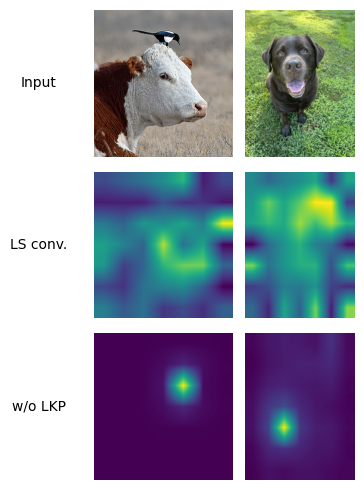

In [31]:
fmaps = []
fmaps_woLKP = []

def process_fmap(feature_maps, size=None):
    fmap = feature_maps.squeeze(0)
    if fmap.ndim > 3:
        fmap = fmap.flatten(0, fmap.ndim - 3)
    print(fmap.shape)
    abs_fmap = torch.abs(fmap)
    heatmap = torch.mean(abs_fmap, dim=0)

    heatmap_np = heatmap.cpu().numpy()
    heatmap_np = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)

    heatmap_smooth = heatmap_np
    if size:
        heatmap_smooth = cv2.resize(heatmap_np, size)

    return heatmap_smooth

for img in images:
    fmap = get_feature_maps(model, "blocks3[-1].mixer.ska", img, high_res=False)
    fmap_woLKP = get_feature_maps(model, "blocks3[-1].mixer.ska", img, off_LKP=True, high_res=False)
    fmap = process_fmap(fmap, size=img.size)
    fmap_woLKP = process_fmap(fmap_woLKP, size=img.size)
    fmaps.append(fmap)
    fmaps_woLKP.append(fmap_woLKP)

row_names = ["Input", "LS conv.", "w/o LKP"]

fig, axs = plt.subplots(3, len(images), figsize=(2 * len(images), 5), squeeze=False)

for i in range(len(images)):
    axs[0, i].imshow(images[i])
    axs[1, i].imshow(fmaps[i], cmap='viridis')
    axs[2, i].imshow(fmaps_woLKP[i], cmap='viridis')

    for row in range(3):
        ax = axs[row, i]
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        for spine in ax.spines.values():
            spine.set_visible(False)

        if i == 0:
            ax.set_ylabel(
                row_names[row], 
                rotation=0,
                labelpad=40,
                va='center'
            )

plt.tight_layout()
plt.show()

## Feature after LKP & SKA
Visualize the features after the large-kernel depth-wise convolution and the small-kernel dynamic convolution in the first stage

The size of tensor a (1763) must match the size of tensor b (16) at non-singleton dimension 3
Feature map with shape: torch.Size([1, 128, 340, 321])
The size of tensor a (1763) must match the size of tensor b (16) at non-singleton dimension 3
Feature map with shape: torch.Size([1, 16, 9, 340, 321])
torch.Size([128, 340, 321])
torch.Size([144, 340, 321])
The size of tensor a (768) must match the size of tensor b (16) at non-singleton dimension 3
Feature map with shape: torch.Size([1, 128, 256, 192])
The size of tensor a (768) must match the size of tensor b (16) at non-singleton dimension 3
Feature map with shape: torch.Size([1, 16, 9, 256, 192])
torch.Size([128, 256, 192])
torch.Size([144, 256, 192])


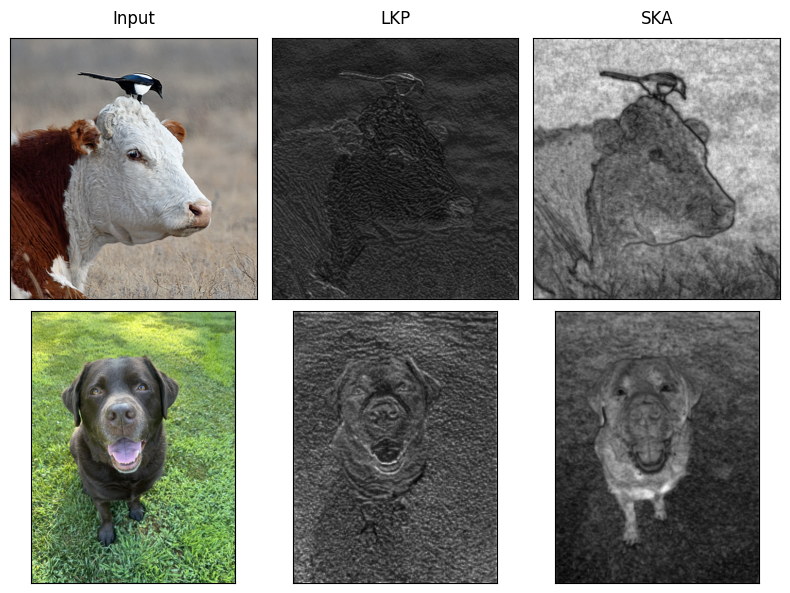

In [34]:
fmaps_SKA = []
fmaps_LKP = []

def process_fmap(feature_maps, size=None):
    fmap = feature_maps.squeeze(0)
    if fmap.ndim > 3:
        fmap = fmap.flatten(0, fmap.ndim - 3)
    print(fmap.shape)
    abs_fmap = torch.abs(fmap)
    heatmap = torch.mean(abs_fmap, dim=0)

    heatmap_np = heatmap.cpu().numpy()
    heatmap_np = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)

    heatmap_smooth = heatmap_np
    if size:
        heatmap_smooth = cv2.resize(heatmap_np, size)

    return heatmap_smooth

for img in images:
    fmap_ska = get_feature_maps(model, "blocks1[1].mixer.ska", img, high_res=True)
    fmap_lkp = get_feature_maps(model, "blocks1[1].mixer.lkp", img, high_res=True)
    fmap_ska = process_fmap(fmap_ska, size=img.size)
    fmap_lkp = process_fmap(fmap_lkp, size=img.size)
    fmaps_SKA.append(fmap_ska)
    fmaps_LKP.append(fmap_lkp)

col_names = ["Input", "LKP", "SKA"]

fig, axs = plt.subplots(len(images), 3, figsize=(8, 3 * len(images)))

for col in range(3):
    axs[0, col].set_title(col_names[col], pad=10)

for i in range(len(images)):
    axs[i, 0].imshow(images[i])
    axs[i, 1].imshow(fmaps_SKA[i], cmap='gray')
    axs[i, 2].imshow(fmaps_LKP[i], cmap='gray')

    for col in range(3):
        ax = axs[i, col]
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()